### This is a preparation of the DeepFM with Tensorflow

- Using the customized Tensorflow functions


### Consideration

- Model Considerations
  1. Initialization Method
     - Glorut
     - **He**
       - ReLu, LeakyReLu, Swish
  2. Activation Function
     - **ReLu**
       - 계산 리소스가 제한될 때
     - **Leaky ReLu**
       - ReLu가 성능이 안좋을때
     - **Swish**
       - 계산량 많은데 성능은 좋음
  3. Batch Normalization
     - stablize the training
     - Apply between the hidden layer and the activation -> no need to apply the bias
  4. Gradient Clipping (opt)
  5. Optimizer
     - **Adam**
       - 기본 옵션
     - **AdamW**
       - 오버피팅 방지용
       - l2 는 못쓰지만 l1은 사용 가능
     - **Nadam**
       - 빠른 훈련이 필요 할 때
  6. Learning Rate Scheduling
     - Performance Base
     - 1Cycle
  7. Custom Loss Function
     - CB-BCE + Ranking Loss
       - Class-Balanced Binary Cross-Entropy (CB-BCE):
         - 클래스 불균형 문제를 해결하기 위해 라벨 빈도에 따라 가중치를 적용.
       - Ranking Loss:
         - 라벨 간 상관관계를 반영하여, 올바른 라벨의 점수가 잘못된 라벨의 점수보다 높도록 학습.


In [16]:
import tensorflow as tf
import numpy as np

# ------------------------------------------------------------------------------------
# 0. 커스텀 F1 스코어 메트릭 정의
# ------------------------------------------------------------------------------------
class F1Score(tf.keras.metrics.Metric):
    """
    이 클래스는 이진 멀티레이블 분류 문제에서 모델의 성능을 평가하기 위한 F1 스코어를 계산합니다.
    F1 스코어는 정밀도(Precision)와 재현율(Recall)의 조화평균입니다.
    
    주요 속성:
      - threshold: 예측값을 1로 판단할 기준 임계값입니다.
      - true_positives: 누적된 True Positive의 수를 저장합니다.
      - false_positives: 누적된 False Positive의 수를 저장합니다.
      - false_negatives: 누적된 False Negative의 수를 저장합니다.
    """
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        # 부모 클래스의 초기화를 수행합니다.
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # 각 카운터를 초기값 0으로 설정하고, 그래프에서 학습 중 업데이트 할 수 있도록 변수로 등록합니다.
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        배치 단위로 호출되어 실제 정답(y_true)과 모델 예측(y_pred)을 받아
        각 샘플에 대한 True Positive, False Positive, False Negative 값을 업데이트 합니다.
        
        매개변수:
          - y_true: 실제 정답 텐서 (실제 값은 0 또는 1로 구성)
          - y_pred: 모델의 예측값 텐서 (보통 확률 값, 0~1 사이)
          - sample_weight: 각 샘플에 부여할 가중치(옵션), 제공 시 각 샘플별 중요도를 반영합니다.
        """
        # 예측값을 threshold(기본값 0.5) 이상이면 1, 미만이면 0으로 이진화합니다.
        y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)
        # 실제 값도 float형으로 변환하여 계산에 일관성을 맞춥니다.
        y_true = tf.cast(y_true, tf.float32)
        
        # 만약 sample_weight가 제공되면, 각 샘플의 결과에 해당 가중치를 곱합니다.
        if sample_weight is not None:
            # sample_weight의 데이터 타입을 현재 메트릭의 데이터 타입으로 변환합니다.
            sample_weight = tf.cast(sample_weight, self.dtype)
            # sample_weight의 차원을 (배치 크기, 1)로 재구성하여 y_true와 y_pred에 올바르게 브로드캐스팅하도록 합니다.
            sample_weight = tf.reshape(sample_weight, (-1, 1))
            y_true = y_true * sample_weight
            y_pred = y_pred * sample_weight

        # True Positive: 실제 1이고 예측도 1인 경우의 합을 계산합니다.
        tp = tf.reduce_sum(y_true * y_pred)
        # False Positive: 실제 0이지만 예측은 1인 경우의 합을 계산합니다.
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        # False Negative: 실제 1인데 예측은 0인 경우의 합을 계산합니다.
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        # 누적 값에 현재 배치의 tp, fp, fn 값을 더합니다.
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        현재까지 누적된 True Positive, False Positive, False Negative를 바탕으로 
        정밀도, 재현율, 그리고 최종 F1 스코어를 계산하여 반환합니다.
        """
        # 정밀도: 실제 예측된 양성 중에서 실제 양성인 비율
        precision = self.true_positives / (
            self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        # 재현율: 실제 양성 중에서 정확하게 예측된 비율
        recall = self.true_positives / (
            self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # F1 스코어: 정밀도와 재현율의 조화평균
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        """
        평가가 완료된 후 또는 새로운 평가 주기 시작 시 누적된 값을 0으로 초기화합니다.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


# ------------------------------------------------------------------------------------
# 1. 라벨 가중치 계산 함수 (Median Frequency Balancing)
# ------------------------------------------------------------------------------------
def compute_label_weights(label_counts: dict) -> tf.Tensor:
    """
    각 라벨의 등장 빈도수를 바탕으로 라벨별 가중치를 계산합니다.
    여기서 가중치는 각 라벨의 빈도에 따라 계산되며, 값이 적은 라벨에 더 높은 가중치를 부여합니다.
    
    계산식:
        weight = (모든 라벨의 등장 빈도의 중앙값) / (해당 라벨의 등장 빈도)
    
    매개변수:
      - label_counts: 각 라벨과 해당 라벨의 등장 빈도를 담은 딕셔너리 (예: {"label": 100})
    
    반환:
      - 알파벳 순으로 정렬된 라벨에 해당하는 가중치 텐서 (tf.float32)
    """
    # 딕셔너리의 value들을 numpy 배열로 변환합니다.
    counts = np.array(list(label_counts.values()), dtype=np.float32)
    # 만약 어떤 라벨의 count가 0이면 0으로 나누는 오류가 발생할 수 있으므로, 0인 경우 1.0으로 치환합니다.
    counts[counts == 0] = 1.0
    # 모든 count의 중앙값을 계산합니다.
    median_count = np.median(counts)
    # 각 라벨에 대해 (중앙값 / count)를 계산하여 가중치 딕셔너리를 생성합니다.
    weights = {label: median_count / count for label, count in label_counts.items()}
    # 라벨의 순서를 알파벳 순으로 정렬하여 일관된 순서를 유지합니다.
    sorted_labels = sorted(label_counts.keys())
    # 정렬된 라벨 순서대로 가중치 값을 리스트로 생성합니다.
    weights_list = [weights[label] for label in sorted_labels]
    # 리스트를 텐서로 변환하여 반환합니다.
    return tf.constant(weights_list, dtype=tf.float32)


# ------------------------------------------------------------------------------------
# 2. DeepFM 모델 클래스 (수치형 입력 데이터용)
# ------------------------------------------------------------------------------------
class DeepFMModel(tf.keras.Model):
    """
    DeepFM 모델은 선형(Linear), 팩터화 머신(FM), 그리고 딥러닝(Deep) 세 파트를 결합하여
    입력된 수치형 데이터를 기반으로 이진 분류를 수행합니다.
    
    구성 요소:
      1. Linear 파트: 단순 선형 변환을 적용하여 각 피처의 직접적인 영향력을 모델링합니다.
      2. FM 파트: 각 피처마다 학습 가능한 임베딩 벡터를 이용하여 2차 상호작용 효과(피처간 곱셈 항)를 모델링합니다.
      3. Deep 파트: 다층 퍼셉트론(MLP)을 통해 입력 피처의 비선형 상호작용을 학습합니다.
    
    최종 출력은 세 파트의 결과를 합산한 후, sigmoid 함수를 통해 0~1 사이의 확률 값으로 변환합니다.
    """
    def __init__(self, num_features: int, embedding_dim: int, num_labels: int,
                 deep_units: list, dropout_rate: float = 0.5, l2_reg: float = 1e-4, **kwargs):
        # 부모 클래스(tf.keras.Model)를 초기화합니다.
        super(DeepFMModel, self).__init__(**kwargs)
        self.num_features = num_features  # 입력 피처의 개수 (예: 7)
        
        # ----- Linear 파트 -----
        # 수치형 입력에 대해 단순 선형 변환을 수행하는 Dense 레이어입니다.
        # 각 피처에 대해 선형 가중치를 학습하여 직접적인 영향력을 모델링합니다.
        self.linear_dense = tf.keras.layers.Dense(
            units=num_labels,  # 출력 차원: 예측할 라벨의 수 (예: 1)
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),  # 과적합 방지를 위한 L2 정규화 적용
            name="linear_dense"
        )
        
        # ----- FM 파트 -----
        # 각 피처에 대해 학습 가능한 임베딩 벡터를 생성합니다.
        # 임베딩 벡터의 차원은 embedding_dim이며, 각 피처의 값과 곱해져서 2차 상호작용을 계산하는 데 사용됩니다.
        self.feature_embedding = self.add_weight(
            name="feature_embedding",
            shape=(num_features, embedding_dim),  # (피처 개수, 임베딩 차원)
            initializer=tf.keras.initializers.GlorotUniform(),  # 가중치 초기화 방식
            regularizer=tf.keras.regularizers.l2(l2_reg)  # L2 정규화 적용
        )
        # FM 상호작용 결과를 num_labels 차원으로 변환하는 Dense 레이어입니다.
        self.fm_dense = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),  # He 초기화 적용
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="fm_dense"
        )
        
        # ----- Deep 파트 -----
        # 수치형 입력을 그대로 MLP(다층 퍼셉트론)에 통과시켜 비선형 특성을 학습합니다.
        # Sequential 모델을 이용하여 여러 개의 Dense 및 Dropout 레이어를 순차적으로 구성합니다.
        self.deep_layers = tf.keras.Sequential(name="deep_sequential")
        for i, units in enumerate(deep_units):
            # 첫 번째 Dense 레이어: 은닉층의 뉴런 수는 deep_units 리스트에 의해 결정됩니다.
            self.deep_layers.add(
                tf.keras.layers.Dense(
                    units=units,
                    activation='relu',  # 활성화 함수로 ReLU 사용
                    kernel_initializer=tf.keras.initializers.HeNormal(),
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                    name=f"deep_dense_{i}"
                )
            )
            # Dropout 레이어를 추가하여 과적합을 방지합니다.
            self.deep_layers.add(
                tf.keras.layers.Dropout(rate=dropout_rate, name=f"deep_dropout_{i}")
            )
        # Deep 파트의 마지막 출력 레이어: 최종 출력 차원은 num_labels입니다.
        self.deep_output = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="deep_output"
        )
    
    @tf.function
    def call(self, inputs, training=False):
        """
        모델의 순전파(forward propagation) 과정을 정의합니다.
        
        매개변수:
          - inputs: (batch_size, num_features) 형태의 입력 텐서
          - training: 학습 모드 여부 (Dropout 등 레이어의 동작에 영향을 줌)
          
        반환:
          - sigmoid 함수를 적용한 최종 예측 확률값 (batch_size, num_labels)
        """
        # [Linear 파트]
        # 입력 데이터를 단순 선형 변환하여 각 피처의 가중치 곱의 합을 계산합니다.
        # 결과 텐서 shape: (batch_size, num_labels)
        linear_out = self.linear_dense(inputs)
        
        # [FM 파트]
        # FM 파트에서는 각 피처의 값과 해당 피처에 대응하는 임베딩 벡터의 곱을 계산합니다.
        # 1. 입력 데이터를 (batch_size, num_features, 1) 형태로 확장하여 각 피처에 대한 별도 차원을 만듭니다.
        x_expanded = tf.expand_dims(inputs, axis=-1)
        # 2. 브로드캐스팅을 이용해 각 피처의 값과 임베딩 벡터를 곱합니다.
        #    결과 텐서 shape: (batch_size, num_features, embedding_dim)
        fm_embeddings = x_expanded * self.feature_embedding
        # 3. 각 피처 임베딩을 모두 합산하여, 피처간 상호작용을 반영하는 벡터를 계산합니다.
        #    summed_embeddings의 shape: (batch_size, embedding_dim)
        summed_embeddings = tf.reduce_sum(fm_embeddings, axis=1)
        # 4. 합산한 임베딩 벡터의 제곱을 계산합니다.
        squared_sum = tf.square(summed_embeddings)
        # 5. 각 피처 임베딩 벡터를 제곱한 후, 합산합니다.
        squared_embeddings = tf.square(fm_embeddings)
        sum_squared = tf.reduce_sum(squared_embeddings, axis=1)
        # 6. FM의 2차 상호작용 효과 계산 공식 적용:
        #    0.5 * ((sum of embeddings)^2 - sum of (squared embeddings))
        fm_interactions = 0.5 * (squared_sum - sum_squared)
        # 7. FM 상호작용 결과를 Dense 레이어를 통해 최종 출력 차원(num_labels)으로 변환합니다.
        fm_out = self.fm_dense(fm_interactions)
        
        # [Deep 파트]
        # 원본 수치형 입력을 그대로 다층 퍼셉트론(MLP)에 전달하여 비선형 특성을 학습합니다.
        deep_out = self.deep_layers(inputs, training=training)
        # Deep 파트의 마지막 출력 레이어를 통과하여 최종 결과를 얻습니다.
        deep_out = self.deep_output(deep_out)
        
        # 세 파트의 출력을 합산합니다.
        logits = linear_out + fm_out + deep_out
        # 합산된 결과에 sigmoid 함수를 적용하여 0과 1 사이의 확률 값으로 변환합니다.
        outputs = tf.keras.activations.sigmoid(logits)
        return outputs


# ------------------------------------------------------------------------------------
# 3. 사용자 정의 손실 함수 (가중치 적용 이진 크로스엔트로피)
# ------------------------------------------------------------------------------------
def weighted_binary_crossentropy(label_weights: tf.Tensor):
    """
    라벨별 가중치를 적용한 이진 크로스엔트로피 손실 함수를 생성합니다.
    
    함수 내부에서는 각 라벨에 대해 미리 계산된 가중치를 곱한 후, 전체 샘플의 평균 손실을 계산합니다.
    
    매개변수:
      - label_weights: 각 라벨에 대한 가중치를 담은 텐서 (예: [가중치1, 가중치2, ...])
    
    반환:
      - 손실 함수 (loss function) that accepts y_true와 y_pred
    """
    def loss_fn(y_true, y_pred):
        # label_weights의 shape을 (1, num_labels)로 재구성하여 y_true, y_pred에 브로드캐스팅합니다.
        lw = tf.reshape(label_weights, [1, -1])
        # 기본 이진 크로스엔트로피 손실을 계산합니다.
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # 각 라벨에 대해 가중치를 곱하여 손실 값을 조정합니다.
        weighted_bce = bce * lw
        # 전체 배치에 대해 평균 손실을 계산하여 반환합니다.
        return tf.reduce_mean(weighted_bce)
    return loss_fn


# ------------------------------------------------------------------------------------
# 4. 옵티마이저 및 학습률 스케줄러 정의
# ------------------------------------------------------------------------------------
def get_optimizer(initial_lr: float = 1e-3) -> tf.keras.optimizers.Optimizer:
    """
    학습률 스케줄러(ExponentialDecay)를 사용하여 점진적으로 학습률을 감소시키고,
    Adam 옵티마이저를 반환하는 함수입니다.
    
    매개변수:
      - initial_lr: 초기 학습률 (default: 0.001)
    
    반환:
      - Adam 옵티마이저 객체 (tf.keras.optimizers.Optimizer)
    """
    # ExponentialDecay 스케줄러를 생성하여, 매 decay_steps마다 학습률을 decay_rate 만큼 감소시킵니다.
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,   # 학습률이 감소하기 전 몇 스텝마다 업데이트할지를 지정합니다.
        decay_rate=0.96,     # 매 업데이트 시 학습률에 곱해질 비율
        staircase=True       # 계단형 감소를 사용 (매 일정 스텝마다 학습률을 떨어뜨림)
    )
    # Adam 옵티마이저에 학습률 스케줄러를 적용하여 반환합니다.
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# ------------------------------------------------------------------------------------
# 5. 프로덕션용 학습 예시
# ------------------------------------------------------------------------------------
if __name__ == "__main__":
    # -----------------------------
    # 1) 하이퍼파라미터 설정
    # -----------------------------
    num_features = 7       # 입력 데이터의 피처 개수 (예: 7개)
    num_labels = 1         # 예측할 라벨의 수 (여기서는 이진 분류이므로 1)
    embedding_dim = 8      # FM 파트에서 각 피처를 임베딩할 차원 (예: 8)
    deep_units = [64, 32]  # Deep 파트 MLP의 은닉층 뉴런 수 리스트 (첫 번째 층 64개, 두 번째 층 32개)
    dropout_rate = 0.5     # Dropout 비율 (과적합 방지)
    l2_reg = 1e-4          # L2 정규화 계수 (과적합 방지)
    
    # -----------------------------
    # 2) 라벨 등장 빈도 기반 가중치 계산
    # -----------------------------
    # 예를 들어, "label"이라는 라벨의 등장 빈도가 100번이라면,
    # Median Frequency Balancing을 적용하여 가중치를 계산합니다.
    label_counts = {"label": 100}
    label_weights = compute_label_weights(label_counts)
    
    # -----------------------------
    # 3) 모델 생성 및 컴파일
    # -----------------------------
    # DeepFM 모델 객체를 생성합니다.
    # 입력 데이터는 (batch_size, num_features) 형태의 수치형 벡터입니다.
    model = DeepFMModel(num_features, embedding_dim, num_labels, deep_units,
                        dropout_rate=dropout_rate, l2_reg=l2_reg)
    # 옵티마이저를 설정합니다.
    optimizer = get_optimizer(initial_lr=1e-3)
    # 모델 컴파일: 옵티마이저, 사용자 정의 손실 함수, 평가 지표(정확도, F1, AUC)를 설정합니다.
    model.compile(
        optimizer=optimizer,
        loss=weighted_binary_crossentropy(label_weights),
        metrics=["accuracy", F1Score(threshold=0.5), tf.keras.metrics.AUC(name="auc")]
    )
    
    # 모델의 입력 형태를 지정하여 빌드합니다. (None: 배치 크기는 유동적, num_features: 7)
    model.build(input_shape=(None, num_features))
    # 모델 구조 요약을 출력합니다.
    model.summary()
    
    # -----------------------------
    # 4) 더미 데이터셋 생성
    # -----------------------------
    # 실제 학습에서는 적절한 train/validation 데이터셋을 사용해야 하지만,
    # 여기서는 예시를 위해 임의의 수치형 데이터를 생성합니다.
    num_samples = 1000  # 전체 샘플 수
    # 각 피처 값은 0~1 사이의 랜덤 실수 값으로 생성 (정규화된 데이터 가정)
    X_dummy = np.random.random(size=(num_samples, num_features)).astype(np.float32)
    # 이진 라벨 (0 또는 1)을 임의로 생성하여 shape: (num_samples, num_labels)
    y_dummy = np.random.randint(0, 2, size=(num_samples, num_labels)).astype(np.float32)
    batch_size = 32  # 배치 크기 설정
    # tf.data.Dataset을 사용하여 데이터를 효율적으로 처리합니다.
    dataset = tf.data.Dataset.from_tensor_slices((X_dummy, y_dummy))
    # 데이터를 섞고(batch), 배치 단위로 묶은 후, prefetch를 통해 성능 최적화를 진행합니다.
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # -----------------------------
    # 5) 콜백(callbacks) 설정
    # -----------------------------
    # 모델 학습 중 조기 종료(EarlyStopping), 최적 모델 저장(ModelCheckpoint), TensorBoard 로그 기록을 위해 설정합니다.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("deepfm_best_model.keras", monitor='val_loss', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir="./logs")
    ]
    
    # -----------------------------
    # 6) 모델 학습
    # -----------------------------
    # 실제 학습 시, train과 validation 데이터를 별도로 사용하여 모델의 일반화 성능을 평가하는 것이 좋습니다.
    model.fit(dataset, epochs=10, validation_data=dataset, callbacks=callbacks)


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'deep_fm_model_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "deep_fm_model_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_dense (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fm_dense (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_sequential (Sequential)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_output (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56 (224.00 B)

 Trainable params: 56 (224.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4754 - auc: 0.4848 - f1_score: 0.3308 - loss: 0.9755 - val_accuracy: 0.4890 - val_auc: 0.4902 - val_f1_score: 0.5175 - val_loss: 0.7450
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4931 - auc: 0.4965 - f1_score: 0.4921 - loss: 0.8472 - val_accuracy: 0.5050 - val_auc: 0.4879 - val_f1_score: 0.5736 - val_loss: 0.7354
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4917 - auc: 0.4922 - f1_score: 0.5424 - loss: 0.7990 - val_accuracy: 0.5090 - val_auc: 0.4895 - val_f1_score: 0.5628 - val_loss: 0.7277
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5293 - auc: 0.5153 - f1_score: 0.5570 - loss: 0.7860 - val_accuracy: 0.5150 - val_auc: 0.4918 - val_f1_score: 0.5900 - val_loss: 0.7248
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5012 - auc: 0.5167 - f1_score: 0.5508 - loss: 0.7532 - val_accuracy: 0.4980 - val_auc: 0.4939 - val_f1_score: 0.5273 - val_loss: 0.

KeyboardInterrupt: 

In [7]:
# 최적으로 찾아진 모델 로드하기
# 저장된 파일 이름은 ModelCheckpoint callback에서 지정한 파일명과 동일해야 합니다.
loaded_model = tf.keras.models.load_model("deepfm_best_model.keras", compile=False)
print("최적 모델이 성공적으로 로드되었습니다.")

# 만약 로드된 모델에 커스텀 객체(예: 커스텀 loss, 메트릭 등)가 포함되어 있다면,
# compile=False 옵션으로 로드한 후 재컴파일하는 것이 좋습니다.

# 재컴파일을 위한 옵티마이저, 손실 함수, 메트릭 정의 (필요한 경우 수정)
# 아래 예시는 이전에 사용한 라벨 가중치와 옵티마이저를 그대로 사용하는 경우입니다.
label_counts = {
    "A": 99,
    "B": 10,
    "C": 50,
    "D": 120,
    "E": 30,
}
label_weights_full = compute_label_weights(label_counts)
label_weights_demo = label_weights_full[:5]  # 예시로 5개 라벨 사용

loaded_model.compile(optimizer=get_optimizer(initial_lr=1e-3),  # 필요에 따라 초기 학습률 조정
                     loss=weighted_binary_crossentropy(label_weights_demo),
                     metrics=["accuracy", F1Score(), tf.keras.metrics.AUC(name="auc")])
print("로드된 모델이 재컴파일되었습니다. 추가 학습이나 추론에 사용할 수 있습니다.")



TypeError: Could not locate class 'DeepFMModel'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DeepFMModel', 'config': {'name': 'deep_fm_model_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'DeepFMModel', 'build_config': {'input_shape': [None, 10]}, 'compile_config': None}

/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'deep_fm_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "deep_fm_model_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_embedding (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_embedding (Embedding)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fm_dense (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_flatten (Flatten)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_sequential (Sequential)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_output (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1361 - auc: 0.5082 - f1_score: 0.5002 - loss: 1.2136 - val_accuracy: 0.2280 - val_auc: 0.7193 - val_f1_score: 0.6837 - val_loss: 1.1913
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2333 - auc: 0.6231 - f1_score: 0.6104 - loss: 1.1968 - val_accuracy: 0.3830 - val_auc: 0.8542 - val_f1_score: 0.7876 - val_loss: 1.1713
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3192 - auc: 0.7297 - f1_score: 0.6872 - loss: 1.1745 - val_accuracy: 0.4370 - val_auc: 0.8917 - val_f1_score: 0.8162 - val_loss: 1.1508
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3615 - auc: 0.7916 - f1_score: 0.7424 - loss: 1.1513 - val_accuracy: 0.4720 - val_auc: 0.9174 - val_f1_score: 0.8410 - val_loss: 1.1248
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3988 - auc: 0.8244 - f1_score: 0.7567 - loss: 1.1296 - val_accuracy: 0.4460 - val_auc: 0.9253 - val_f1_score: 0.8480 - val_loss: 1.

### Subclass FM


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

import matplotlib.pyplot as plt

import math

### 1, 2. Initializer and Activation


In [ ]:
# ReLu
dense = tf.keras.layers.Dense(50,
                              activation = 'relu',
                              kernel_initializer = 'he_normal')

# Elu
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

# Leaky ReLu
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # 기본값 alpha=0.3
dense = tf.keras.layers.Dense(50,
                              activation=leaky_relu,
                              kernel_initializer="he_normal")

dense = tf.keras.layers.Dense(100,
                              activation="swish",
                             kernel_initializer="he_normal")

### 3. Batch Norm


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

### 5. Optimizers


In [3]:


random_seed = 0

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=random_seed):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))
    
    
    
# SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer) 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum= 0.9)
history_momentum = build_and_train_model(optimizer) 
# Nesterov
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)  

# AdaGrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer) 

# RMSProp
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)  

# Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

# Adamax
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

## Nadam
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

## AdamW
# %pip install -q -U tensorflow-addons
# import tensorflow_addons as tfa
#optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)

optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)
    

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.4298 - loss: 1.8238 - val_accuracy: 0.7014 - val_loss: 0.8990
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.7186 - loss: 0.8435 - val_accuracy: 0.7620 - val_loss: 0.6924
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - accuracy: 0.7701 - loss: 0.6782 - val_accuracy: 0.7888 - val_loss: 0.6106
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.7968 - loss: 0.6010 - val_accuracy: 0.8020 - val_loss: 0.5627
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8130 - loss: 0.5542 - val_accuracy: 0.8122 - val_loss: 0.5310
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8218 - loss: 0.5228 - val_accuracy: 0.8208 - val_loss: 0.5092
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.8276 - loss: 0.5006 - val_accuracy: 0.8246 - val_loss: 0.4927
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.8320 -

### 6. Learning Rate


### 6. Finding the best Learning Rate


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.2681 - loss: 2.1110


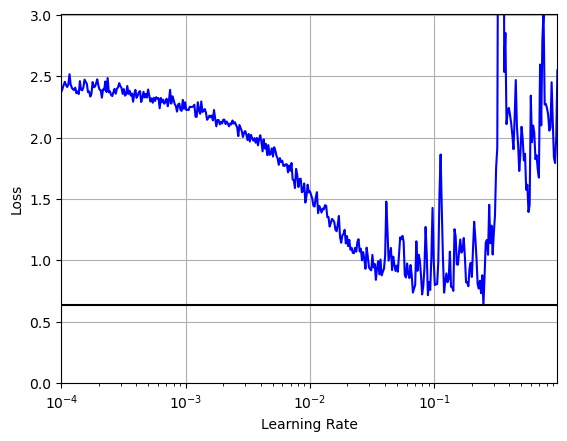

In [22]:


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor  # 학습률 증가 계수
        self.rates = []       # 학습률 기록
        self.losses = []      # 배치 손실 기록

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0  # 에포크 손실 초기화

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # 현재까지 평균 손실
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)  # 누적 손실 합 계산
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses  # 배치 손실 계산
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))  # 학습률 저장
        self.losses.append(batch_loss)  # 배치 손실 저장
        
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate * self.factor)  # 학습률 증가


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1):
    init_weights = model.get_weights()  # 초기 가중치 저장
    iterations = math.ceil(len(X) / batch_size) * epochs  # 총 배치 수 계산
    factor = (max_rate / min_rate) ** (1 / iterations)  # 학습률 증가 계수 계산
    init_lr = K.get_value(model.optimizer.learning_rate)  # 초기 학습률 저장
    model.optimizer.learning_rate.assign(min_rate)  # 초기 학습률 설정
    exp_lr = ExponentialLearningRate(factor)  # 콜백 생성
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])  # 학습 진행
    model.optimizer.learning_rate.assign(init_lr)  # 초기 학습률 복원
    model.set_weights(init_weights)  # 모델 가중치 복원
    return exp_lr.rates, exp_lr.losses  # 학습률과 손실 반환

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')  # 학습률을 로그 스케일로 설정
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")  # 최소 손실 라인 표시
    plt.axis([min(rates), max(rates), 0, max_loss])  # 그래프 축 범위 설정
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.grid()
    
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)


In [27]:
model = build_model()

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.6926 - loss: 0.9356 - val_accuracy: 0.8260 - val_loss: 0.4940 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.8306 - loss: 0.4851 - val_accuracy: 0.8426 - val_loss: 0.4420 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8486 - loss: 0.4307 - val_accuracy: 0.8506 - val_loss: 0.4161 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.8576 - loss: 0.4000 - val_accuracy: 0.8536 - val_loss: 0.4055 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.8647 - loss: 0.3780 - val_accuracy: 0.8560 - val_loss: 0.3982 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.8704 - loss: 0.3607 - val_accuracy: 0.8584 - val_loss: 0.3915 - learning_rate: 0.0100
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accura

In [28]:
"""
1. 초기 구간에서는 학습률을 선형적으로 증가.
2. 중간 구간에서는 학습률을 선형적으로 감소.
3. 마지막 구간에서는 학습률을 극도로 낮은 값으로 줄임.
"""
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        """
        OneCycle 학습률 스케줄러 초기화.

        Args:
            iterations (int): 총 배치 수. (예: steps_per_epoch * epochs)
                             예시: len(X_train) / batch_size * n_epochs = 500 * 10 = 5000
            max_lr (float): 학습률의 최대값 (Peak Learning Rate).
                            예시: 0.2
            start_lr (float, optional): 학습률 시작값 (Warm-up의 초기값). 기본값은 max_lr / 10.
                                        예시: max_lr=0.2이면 start_lr=0.02.
            last_iterations (int, optional): 마지막 학습률 단계의 배치 수. 기본값은 총 배치 수의 10%.
                                              예시: iterations=5000이면 last_iterations=500.
            last_lr (float, optional): 마지막 학습률의 값. 기본값은 start_lr / 1000.
                                       예시: start_lr=0.02이면 last_lr=0.00002.
        """
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10  # 초기 학습률 (기본값은 max_lr의 1/10)
        self.last_iterations = last_iterations or iterations // 10 + 1 # 마지막 구간 배치 수
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.ㅠ = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        """
        두 학습률 값 사이를 (interpolation).

        Args:
            iter1 (int): 시작 배치 번호.
            iter2 (int): 종료 배치 번호.
            lr1 (float): 시작 학습률 값.
            lr2 (float): 종료 학습률 값.

        Returns:
            float: 현재 배치에 해당하는 학습률.
        """
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate.assign(lr)
        
        
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.2)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6461 - loss: 1.0840 - val_accuracy: 0.7956 - val_loss: 0.5743
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.8108 - loss: 0.5395 - val_accuracy: 0.8158 - val_loss: 0.5123
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.8356 - loss: 0.4645 - val_accuracy: 0.8190 - val_loss: 0.5025
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8473 - loss: 0.4254 - val_accuracy: 0.8202 - val_loss: 0.4954
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8566 - loss: 0.3985 - val_accuracy: 0.8294 - val_loss: 0.4722
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.8622 - loss: 0.3788 - val_accuracy: 0.8274 - val_loss: 0.4611
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8670 - loss: 0.3638 - val_accuracy: 0.8296 - val_loss: 0.4589
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.8708 - loss: 0.3519 - va

### 7. Customized Loss&Metric Function

- **Class-Balanced Binary Cross-Entropy (CB-BCE)**
  - 클래스 불균형 문제를 해결하기 위해 라벨 빈도에 따라 가중치를 적용.
    $$
        \text{CB-BCE} = - w_i \cdot \left( y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right)
    $$

$$
w_i = \frac{1 - \beta}{1 - \beta^{n_i}}
$$

- **Ranking Loss**

  - 라벨 간 상관관계를 반영하여, 올바른 라벨의 점수가 잘못된 라벨의 점수보다 높도록 학습.
    $$
    \text{Ranking Loss} = \sum_{i,j} \max(0, \text{margin} - (\hat{y}_i - \hat{y}_j))
    $$

- **Class-Balanced BCE + Ranking Loss**
  $$
  \text{Final Loss} = \alpha \cdot \text{CB-BCE} + \beta \cdot \text{Ranking Loss}
  $$


| 특징                   | `class_weight`                                                                   | `sample_weight`                                       |
| ---------------------- | -------------------------------------------------------------------------------- | ----------------------------------------------------- |
| **가중치 부여 방식**   | 클래스(라벨) 단위로 적용                                                         | 개별 샘플 단위로 적용                                 |
| **적용 대상**          | `y_train`이 정수(라벨)일 때만 사용 가능                                          | `y_train`이 원-핫 인코딩이어도 사용 가능              |
| **불균형 데이터 대응** | 한 클래스가 많을 때, 해당 클래스의 가중치를 낮추고 희소한 클래스의 가중치를 높임 | 같은 클래스 내에서도 특정 샘플만 강조 가능            |
| **사용 예시**          | 클래스 0: 90%, 클래스 1: 10% → 클래스 1에 더 높은 가중치 부여                    | 클래스 1 내에서도 중요한 샘플에만 더 높은 가중치 부여 |
| **적용 방법**          | `class_weight={0: 1.0, 1: 10.0}`                                                 | `sample_weight=[1.0, 0.5, 2.0, ...]`                  |


In [4]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='custom_huber_metric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    
    # 한 배치(batch)마다 메트릭 값 업데이트
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
    
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())

model.save("./120/my_model_with_a_custom_metric.keras")

model = tf.keras.models.load_model(
    "./120/my_model_with_a_custom_metric.keras",
    custom_objects={
        "HuberLoss": HuberLoss,
        "HuberMetric": HuberMetric
    }
)
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/10


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - custom_huber_metric: 1.0352 - loss: 0.5071
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - custom_huber_metric: 0.3075 - loss: 0.1548
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - custom_huber_metric: 0.2518 - loss: 0.1265
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - custom_huber_metric: 0.2283 - loss: 0.1149
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - custom_huber_metric: 0.2167 - loss: 0.1091
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - custom_huber_metric: 0.2092 - loss: 0.1053
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - custom_huber_metric: 0.2038 - loss: 0.1026
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - custom_huber_metric: 0.2003 - loss: 0.1008
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - custom_huber_metric: 0.1973 - loss: 0.0993
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - custom_huber_metric: 0.1944 - loss: 0.0978
Epoch 1/2
363/363 ━━

In [61]:
history.history

{'custom_huber_metric': [0.6583521962165833,
  0.28962016105651855,
  0.23281827569007874,
  0.2108340561389923,
  0.1999504119157791,
  0.19300642609596252,
  0.18813201785087585,
  0.18409395217895508,
  0.18154661357402802,
  0.1790149211883545],
 'loss': [0.33349132537841797,
  0.14674682915210724,
  0.11791014671325684,
  0.10649929940700531,
  0.10082095116376877,
  0.09718630462884903,
  0.09458249807357788,
  0.0924915000796318,
  0.09113796800374985,
  0.08985715359449387]}

## Custom Model

**`keras.Model`을 상속한 커스텀 모델 구성 요소**
| 구성 요소 | 설명 | 주요 역할 |
|-----------|--------------------------------|------------------|
| `__init__()` | 모델의 층(layer)과 하이퍼파라미터 정의 | 네트워크 구조 생성 |
| `call(inputs)` | 순전파(forward pass) 정의 | 데이터 입력 → 출력 변환 |
| `build(input_shape)` | 입력 데이터 크기를 기반으로 가중치 초기화 | 가중치 생성 및 배치 크기 고려 |
| `compile()` | 손실 함수, 옵티마이저, 평가 지표 설정 | 학습을 위한 설정 |
| `fit()` | 데이터 학습 | 모델 훈련 실행 |
| `evaluate()` | 테스트 데이터 평가 | 모델 성능 평가 |
| `predict()` | 입력 데이터 예측 | 새로운 데이터에 대한 예측 |
| `get_config()` | 모델 저장 및 로드 시 설정 유지 | 모델 직렬화 지원 |

---


## 같은함수


In [90]:
from keras.utils import plot_model

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Define layers
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate() # this layer connect two dense layers horizontally
output_layer = tf.keras.layers.Dense(1)

# Construct the functional model
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2]) # short path from input to hidden2 layer
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

model.summary()

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - custom_huber_metric: 1.0809 - loss: 0.5299
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - custom_huber_metric: 0.6882 - loss: 0.3384
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - custom_huber_metric: 0.6723 - loss: 0.3307
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - custom_huber_metric: 0.6678 - loss: 0.3284
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - custom_huber_metric: 0.6663 - loss: 0.3276
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - custom_huber_metric: 0.6657 - loss: 0.3273
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - custom_huber_metric: 0.6653 - loss: 0.3271
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - custom_huber_metric: 0.6647 - loss: 0.3268
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - custom_huber_metric: 0.6648 - loss: 0.3268
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - custom_huber_metric: 0.6640 - loss: 0.3265


(0.40507376194000244, np.float64(0.40767815774937904))

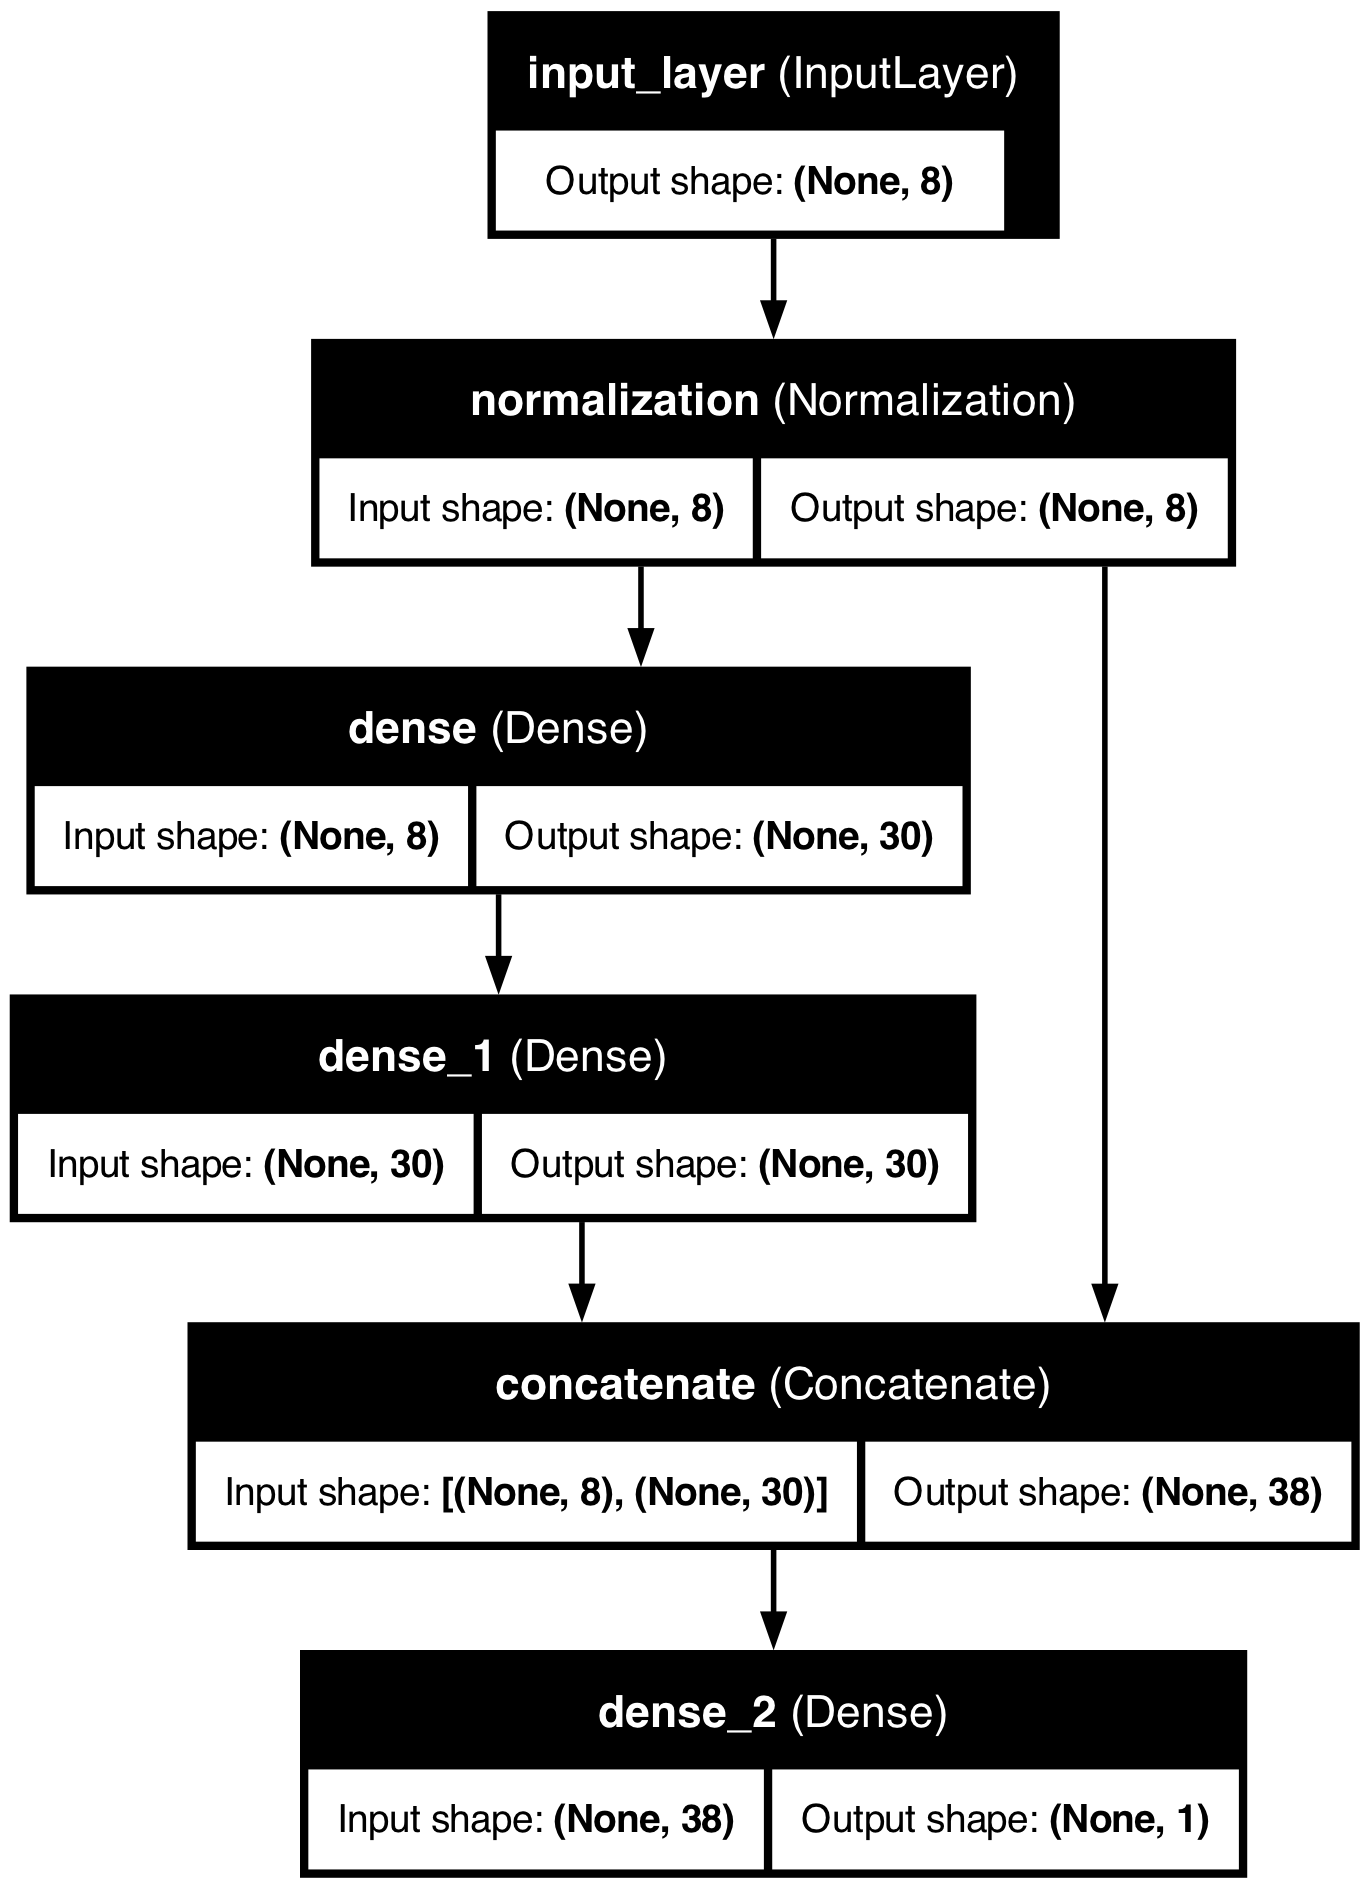

In [91]:
# 모델 그리기
plot_model(model, to_file='./100/functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [5]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   tf.keras.utils.set_random_seed(42)
   random.seed(2)

#make some random data
reset_random_seeds()

# 데이터 로드
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

tf.keras.backend.clear_session()


# 커스텀 모델 정의
class CustomHousingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_layer = tf.keras.layers.InputLayer(shape=(8,))  # 🔹 입력 크기 지정
        self.normalization = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu")
        self.hidden2 = tf.keras.layers.Dense(30, activation="relu")
        self.concat = tf.keras.layers.Concatenate()
        self.output_layer = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        """레이어들의 입력 크기를 명시적으로 정의"""
        self.normalization.build(input_shape)  # 정규화 레이어 빌드
        self.hidden1.build(input_shape)  # 첫 번째 Dense 레이어 빌드
        self.hidden2.build((None, 30))  # 두 번째 Dense 레이어 빌드
        self.concat.build([(None, 8), (None, 30)])
        self.output_layer.build((None, 38))  # Concatenate 이후 크기 (8 + 30)

        # 모델이 빌드되었음을 선언
        self.built = True
        
    def call(self, inputs):
        normalized = self.normalization(inputs)  # 정규화
        hidden1 = self.hidden1(normalized)  # 첫 번째 은닉층
        hidden2 = self.hidden2(hidden1)  # 두 번째 은닉층
        concat = self.concat([normalized, hidden2])  # Shortcut 연결
        output = self.output_layer(concat)  # 최종 출력층
        return output

# 모델 인스턴스 생성
custom_model = CustomHousingModel()

# 모델 빌드 (입력 크기 지정)
custom_model.build(input_shape=(None, X_train.shape[1]))

# 모델 요약 출력
custom_model.summary()

custom_model.compile(loss=HuberLoss(2.0), optimizer="adam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = custom_model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())



Model: "custom_housing_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - custom_huber_metric: 1.0797 - loss: 0.5343
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - custom_huber_metric: 0.6950 - loss: 0.3451
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - custom_huber_metric: 0.6735 - loss: 0.3344
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - custom_huber_metric: 0.6673 - loss: 0.3311
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - custom_huber_metric: 0.6652 - loss: 0.3301
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - custom_huber_metric: 0.6646 - loss: 0.3298
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - custom_huber_metric: 0.6636 - loss: 0.3293
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - custom_huber_metric: 0.6638 - loss: 0.3295
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - custom_huber_metric: 0.6634 - loss: 0.3291
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - custom_huber_metric: 0.6636 - loss: 0.3293


(0.4068768620491028, np.float64(0.4077518466796753))

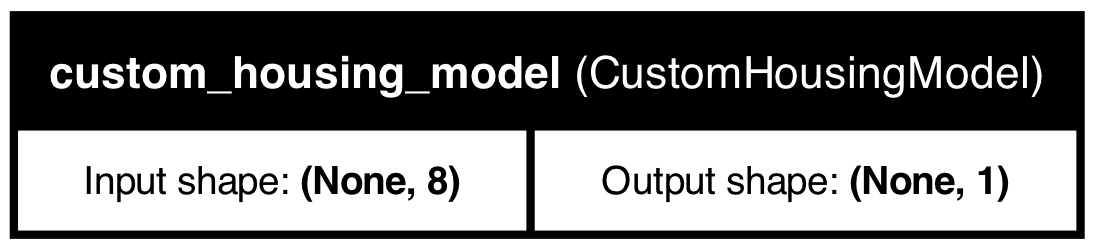

In [10]:
from keras.utils import plot_model
_ = custom_model(tf.keras.Input(shape=(8,)))  # 가짜 입력 데이터 흐름 생성

# 모델 그리기
plot_model(custom_model, to_file='./100/custom_functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


# 추가 코드 - 데이터셋을 20개 파일로 분할하여 CSV 파일로 저장합니다.

import numpy as np # type: ignore
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    # 1. Define the directory path where the CSV files will be saved
    housing_dir = Path("./130/") / "datasets" / "housing" #    The directory structure is "./130/datasets/housing".
    housing_dir.mkdir(parents=True, exist_ok=True) # 2. Create the directory (including any necessary parent directories) if it doesn't already exist.
    
    # 3. Define the naming format for the CSV files.
    #    Each file will follow the format "my_<name_prefix>_<file_index>.csv".
    filename_format = "my_{}_{:02d}.csv" # format rules after ":", fill 0, minium 2 digis, d for integers

    # 4. Initialize an empty list to store the file paths of the created CSV files.
    filepaths = []
    # 5. Determine the total number of rows in the data.
    m = len(data)
    # 6. Split the indices of the data into 'n_parts' chunks to divide the dataset evenly.
    chunks = np.array_split(np.arange(m), n_parts)

    # 7. Loop over each chunk to save the corresponding rows into a separate CSV file.
    for file_idx, row_indices in enumerate(chunks):
        # 8. Generate the file path for the current chunk using the naming format.
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        # 9. Append the generated file path to the filepaths list for later reference.
        filepaths.append(str(part_csv))
        
        # 10. Open the file in write mode and write the data.
        with open(part_csv, "w") as f:
            # 11. If a header is provided, write it as the first line of the file.
            if header is not None:
                f.write(header)
                f.write("\n")
            # 12. Write each row of data in the current chunk as a comma-separated line.
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    
    # 13. Return the list of file paths for the created CSV files.
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)


"""
tf.data.Dataset.list_files: 파일 경로를 데이터셋으로 변환.
TextLineDataset: 파일 내용을 텍스트 라인 단위로 읽어 처리.
skip(1): 헤더 제거.
interleave: 여러 파일을 병렬로 읽고, 데이터를 하나의 데이터셋으로 결합.
"""
random_seed = 42

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed = random_seed)

for item in filepath_dataset:
    print(item)
    
    



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

"""
parse_csv_line
    목적: CSV 파일의 각 열에 대한 기본값(record_defaults)을 정의
    구조:
        [0.] * n_inputs: 입력 데이터(X)에 대해 기본값을 0.0으로 설정.
        n_inputs: CSV 파일의 입력 피처 개수를 나타냄.
        [tf.constant([], dtype=tf.float32)]: 출력 데이터(y)에 대해 기본값을 빈 텐서([])로 설정.
        빈 텐서는 실제 데이터가 있을 때 해당 위치를 채울 수 있도록 gka,
    예제:
        line = "1.0,2.0,3.0,4.0", defs = [0.0, 0.0, 0.0, tf.constant([], dtype=tf.float32)]
        결과: [1.0, 2.0, 3.0, 4.0] (1D 텐서 형태).
        
"""
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype = tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)  # 스칼라 텐서 반환
    # fields = [tf.Tensor(4.5), tf.Tensor(3.2), ..., tf.Tensor(4.8), tf.Tensor(1.0)]
    
    
    #X = tf.stack([4.5, 3.2, 6.8, 2.1, 5.5, 7.2, 3.6, 4.8])
    #y = tf.stack([1.0])
    return tf.stack(fields[:-1]), tf.stack(fields[-1:]) # stack makes field to 1D tensor

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')



"""
Parameters
    - filepaths: 읽어들일 CSV 파일들의 경로 리스트. 예: ["file1.csv", "file2.csv"].
    - n_readers: 동시에 읽을 파일 개수. 병렬적으로 데이터를 읽어 성능을 향상.
    - n_read_threads: 파일 읽기 작업에 사용할 쓰레드 수. 기본값 None인 경우 TensorFlow가 자동으로 최적의 쓰레드 수를 설정.
    - n_parse_threads: 데이터 파싱에 사용할 쓰레드 수.
    - shuffle_buffer_size: 데이터 섞기(shuffling)에 사용할 버퍼 크기. 클수록 더 잘 섞이지만 메모리 사용량 증가.
    - seed: 랜덤 시드 값. 동일한 순서를 재현할 수 있음.
    - batch_size: 데이터 배치 크기. 한 번에 반환할 데이터 샘플 수.
"""

def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=tf.data.AUTOTUNE,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32, repeat = True):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed) # 주어진 파일 경로(filepaths)를 기반으로 랜덤하게 섞인 데이터셋
    """
    interleave:
        여러 파일을 병렬로 읽고 데이터를 결합.
        cycle_length=n_readers: 동시에 읽을 파일 수.
        num_parallel_calls=n_read_threads: 병렬로 읽기 위한 쓰레드 수.
        tf.data.TextLineDataset(filepath).skip(1):

        CSV 파일을 한 줄씩 읽는 데이터셋 생성.
        .skip(1): CSV 파일의 헤더(첫 번째 줄)를 건너뜀.
    """
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads)
    
    """
    map(preprocess):
        preprocess 함수를 사용해 각 줄 데이터를 전처리.
        num_parallel_calls=n_parse_threads: 여러 쓰레드에서 병렬로 전처리 작업 수행.
        
        preprocess의 동작:
            parse_csv_line으로 데이터를 파싱하여 입력(X)과 출력(y)을 나눔.
            입력(X)은 정규화((x - X_mean) / X_std) 수행.
    """
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    """
    shuffle:
        데이터를 랜덤하게 섞어 모델 학습의 편향을 방지.
        shuffle_buffer_size=10_000: 10,000개의 데이터를 메모리에 유지하며 섞음.
    """
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    
    """
    batch(batch_size):
        데이터셋을 지정된 크기(batch_size)로 나눔.
        예: batch_size=32이면 32개의 샘플이 하나의 배치로 반환.
    
    prefetch(1):
        데이터를 미리 로드하여 모델 학습 중 데이터 I/O 병목을 방지.
        학습이 진행되는 동안 다음 배치를 미리 준비.

    """
    
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(1)
    if repeat:
        dataset = dataset.repeat()
    return dataset


#tf.keras.backend.clear_session()

train_set = csv_reader_dataset(train_filepaths, repeat= True)
valid_set = csv_reader_dataset(valid_filepaths, repeat= True)
test_set = csv_reader_dataset(test_filepaths, repeat=False)

n_train_samples = len(X_train)
n_valid_samples = len(X_valid)

batch_size = 32

steps_per_epoch = n_train_samples // batch_size  # 한 에폭 동안 처리할 배치 수
validation_steps = n_valid_samples // batch_size  # 한 에폭 동안 처리할 검증 배치 수

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")


model.fit(train_set,steps_per_epoch = steps_per_epoch,
          validation_data=valid_set, validation_steps= validation_steps,
          epochs=15,
          )


    